In [51]:
'''   

following noaa processing workflow from https://github.com/dataquestio/project-walkthroughs/blob/master/weather/weather.ipynb

'''


import pandas as pd

# Read the first CSV file into a DataFrame
df1 = pd.read_csv('noaa_jfk_data.csv')

# Read the second CSV file into another DataFrame
df2 = pd.read_csv('/Users/samdvorin/Desktop/code/542/weather-prediction/noaa_chi_aus_mia.csv')

# Concatenate the two DataFrames vertically (row-wise)
combined_df = pd.concat([df1, df2], ignore_index=True)

print(combined_df['NAME'].unique())





['JFK INTERNATIONAL AIRPORT, NY US'
 'AUSTIN BERGSTROM INTERNATIONAL AIRPORT, TX US'
 'CHICAGO MIDWAY AIRPORT 3 SW, IL US' 'MIAMI OPA LOCKA AIRPORT, FL US']


In [56]:
core_weather = combined_df[["NAME", "DATE", "PRCP", "SNOW", "SNWD", "TMAX", "TMIN"]].copy()
core_weather.columns = ["name", "date", "precip", "snow", "snow_depth", "temp_max", "temp_min"]
core_weather.apply(lambda x: (x == 9999).sum())

# Convert the 'date_column' to datetime if it's not already
core_weather['date'] = pd.to_datetime(core_weather['date'])
# Set the 'date_column' as the index
core_weather.set_index('date', inplace=True, drop=True)

#print(core_weather.isna().sum())




name             0
precip        3251
snow          9796
snow_depth    9752
temp_max       249
temp_min       312
dtype: int64


In [43]:
import pandas as pd

# Assuming 'core_weather' is your DataFrame

# Get distinct values in the "name" column
distinct_names = core_weather['name'].unique()

# Create a dictionary to store DataFrames for each distinct name
city_data = {}

# Mapping of original names to desired abbreviations
name_to_abbreviation = {
    'JFK INTERNATIONAL AIRPORT, NY US': 'nyc',
    'AUSTIN BERGSTROM INTERNATIONAL AIRPORT, TX US': 'aus',
    'CHICAGO MIDWAY AIRPORT 3 SW, IL US': 'chi',
    'MIAMI OPA LOCKA AIRPORT, FL US': 'mia'
}

# Iterate over each distinct name and create a separate DataFrame for it
for name in distinct_names:
    # Select rows where the 'name' column matches the current distinct name
    df_for_name = core_weather[core_weather['name'] == name].copy()
    # Use the mapping to change the key
    city_data[name_to_abbreviation[name]] = df_for_name

# Now 'dataframes_by_name' contains separate DataFrames for each distinct name
# Keys are now the desired abbreviations


<AxesSubplot:xlabel='date'>

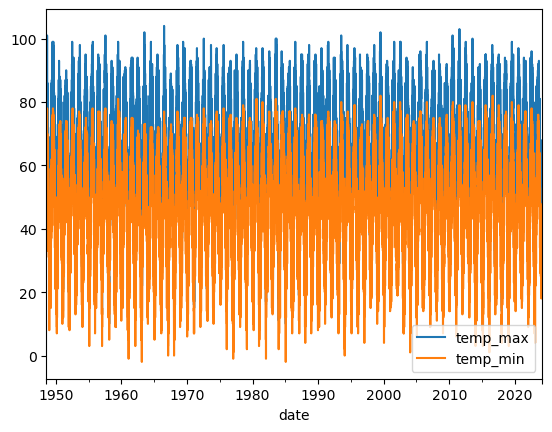

In [9]:
city_data['nyc'][["temp_max", "temp_min"]].plot()

In [44]:
# Iterate over each DataFrame in dataframes_by_name and apply the operation
for name, df in city_data.items():
    # Apply the operation to create the "target" column
    df["target"] = df.shift(-1)["temp_max"]
    df = df.iloc[:-1,:].copy()



In [45]:
testdf = city_data['nyc'].copy()
testdf

,name,precip,snow,snow_depth,temp_max,temp_min,target
date,,,,,,,
1948-07-17,"JFK INTERNATIONAL AIRPORT, NY US",0.06,0.0,0.0,74.0,64.0,81.0
1948-07-18,"JFK INTERNATIONAL AIRPORT, NY US",0.00,0.0,0.0,81.0,70.0,85.0
1948-07-19,"JFK INTERNATIONAL AIRPORT, NY US",0.00,0.0,0.0,85.0,70.0,84.0
1948-07-20,"JFK INTERNATIONAL AIRPORT, NY US",0.00,0.0,0.0,84.0,69.0,85.0
1948-07-21,"JFK INTERNATIONAL AIRPORT, NY US",2.45,0.0,0.0,85.0,71.0,81.0
...,...,...,...,...,...,...,...
2024-03-10,"JFK INTERNATIONAL AIRPORT, NY US",0.03,0.0,0.0,53.0,37.0,53.0
2024-03-11,"JFK INTERNATIONAL AIRPORT, NY US",0.00,0.0,0.0,53.0,35.0,67.0
2024-03-12,"JFK INTERNATIONAL AIRPORT, NY US",0.00,0.0,0.0,67.0,41.0,57.0


In [49]:
testdf.drop(columns=["name"], inplace=True)
testdf['year'] = testdf.index.year
# Regularize the year to start at 0 from 1948
testdf['year'] = testdf['year'] - 1948
testdf['month'] = testdf.index.month
testdf['day'] = testdf.index.day
testdf.dropna(inplace=True)
print(testdf)

            precip  snow  snow_depth  temp_max  temp_min  target  year  month  \
date                                                                            
1948-07-17    0.06   0.0         0.0      74.0      64.0    81.0     0      7   
1948-07-18    0.00   0.0         0.0      81.0      70.0    85.0     0      7   
1948-07-19    0.00   0.0         0.0      85.0      70.0    84.0     0      7   
1948-07-20    0.00   0.0         0.0      84.0      69.0    85.0     0      7   
1948-07-21    2.45   0.0         0.0      85.0      71.0    81.0     0      7   
...            ...   ...         ...       ...       ...     ...   ...    ...   
2024-03-07    0.15   0.0         0.0      55.0      44.0    66.0    76      3   
2024-03-08    0.00   0.0         0.0      66.0      39.0    49.0    76      3   
2024-03-10    0.03   0.0         0.0      53.0      37.0    53.0    76      3   
2024-03-11    0.00   0.0         0.0      53.0      35.0    67.0    76      3   
2024-03-12    0.00   0.0    

In [47]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
